In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import scipy
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import scipy
from sklearn.manifold import TSNE
import seaborn as sn
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
from scipy.stats import cauchy

In [47]:
x = cauchy.rvs(loc=0, scale=1, size=1000) 
y = (x.astype('int32'))
type(y)

numpy.ndarray

In [5]:
import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = 1 / ( 1 +  np.square( (D.copy() * beta - 1 )/10 )) * np.pi*10
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y



def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    #P = P[~np.isnan(P)]
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


In [6]:
#dataread

OP_df = pd.read_csv('OptionData12110.csv')
OP_df=OP_df.dropna()
OP_df['Pdiff'] =  OP_df['Strike_price'] - OP_df['Stock_price'] 
OP_df.head(1)
COP_df = OP_df. loc[OP_df['Option_type'] == 1]
POP_df = OP_df.loc[OP_df['Option_type'] == 0]

#OP_df['Pdiff'] = OP_df.apply(lambda x: int(x['Stock_price']) - int(x['Stock_price']), axis=1)
def func(x):
    if x > 0 :
        return 'OTM'
    elif x < 0 :
        return 'ITM'
    else:
        return 'ATM'
    
def pfunc(x):
    if x > 0 :
        return 'PUT_ITM'
    elif x < 0 :
        return 'PUT_OTM'
    else:
        return 'PUT_ATM'

COP_df['Type'] = COP_df['Pdiff'].apply(func)
POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)

COP_df = COP_df.drop(['Pdiff'], axis = 1)
POP_df = POP_df.drop(['Pdiff'], axis = 1)

frames = [COP_df, POP_df]

df = pd.concat(frames)
df.head(1)

C:\Users\chsha\AppData\Local\Temp/ipykernel_11404/926807002.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COP_df['Type'] = COP_df['Pdiff'].apply(func)
C:\Users\chsha\AppData\Local\Temp/ipykernel_11404/926807002.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)


,Unnamed: 0,Option_type,Ask,Bid,Option_price,Stock_price,Strike_price,Volatility,Volume,Time_to_maturity,Implied_volatility,Type
0,0,1,0.2,0.0,0.09,79.54,45.0,0.286563,4,0.123288,0.763674,ITM


In [79]:
POP_df = POP_df[:100]

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 6069...
Computing P-values for point 500 of 6069...
Computing P-values for point 1000 of 6069...
Computing P-values for point 1500 of 6069...
Computing P-values for point 2000 of 6069...
Computing P-values for point 2500 of 6069...
Computing P-values for point 3000 of 6069...
Computing P-values for point 3500 of 6069...
Computing P-values for point 4000 of 6069...
Computing P-values for point 4500 of 6069...
Computing P-values for point 5000 of 6069...
Computing P-values for point 5500 of 6069...
Computing P-values for point 6000 of 6069...
Mean value of sigma: 0.000000
Iteration 10: error is 25.298886
Iteration 20: error is 25.212727
Iteration 30: error is 23.614167
Iteration 40: error is 21.538850
Iteration 50: error is 20.442980
Iteration 60: error is 19.873339
Iteration 70: error is 19.536234
Iteration 80: error is 19.303146
Iteration 90: error is 19.130899
Iteration 100: error is 

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


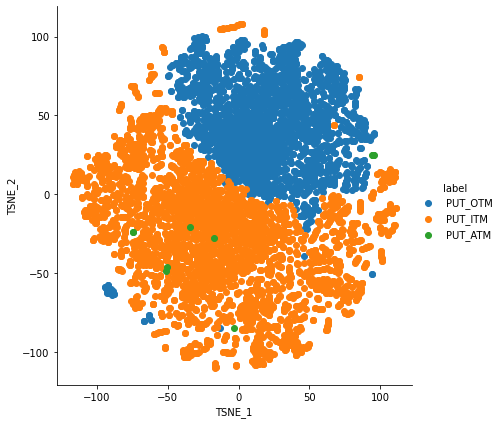

In [7]:
#TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(POP_df.Type)
POP_df['cat'] = le.transform(POP_df.Type)

l = POP_df.Type

data = POP_df.drop(['Type'], axis = 1)

s_data = StandardScaler().fit_transform(data)

X = s_data


Y = tsne(X, 2, 90, 10.0)



tsne_data = Y

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


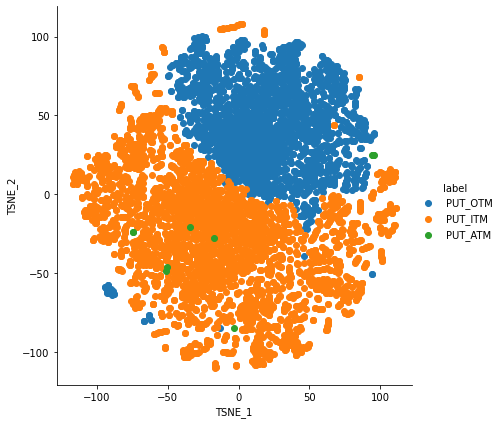

In [8]:

tsne_data = Y

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

In [11]:
COP_df.head(1)

,Unnamed: 0,Option_type,Ask,Bid,Option_price,Stock_price,Strike_price,Volatility,Volume,Time_to_maturity,Implied_volatility,Type
0,0,1,0.2,0.0,0.09,79.54,45.0,0.286563,4,0.123288,0.763674,ITM


C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


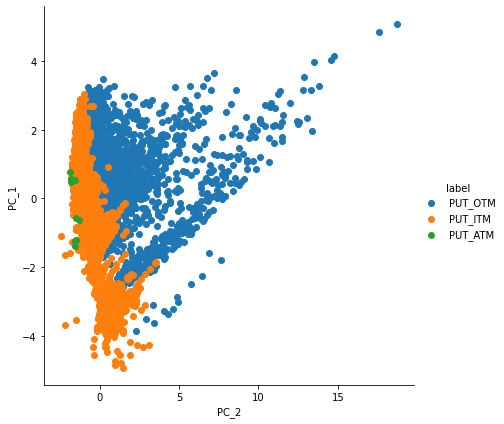

In [23]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(POP_df.Type)
POP_df['cat'] = le.transform(POP_df.Type)
d = POP_df
d = d.drop(['Type'], axis = 1)

norm = StandardScaler().fit_transform(d)
pca = PCA(n_components = 2)
n = pca.fit_transform(norm)

np.shape(n)

tsne_data = n

tsne_data = np.vstack((tsne_data.T, POP_df.Type)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("PC_2", "PC_1", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter,"PC_2", "PC_1").add_legend()
 
plt.show()

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
    
def metric(p,t):
    mse = mean_squared_error(t,p)
    
    r = r2_score( t , p ,  multioutput='variance_weighted')
    
    return mse,r

In [7]:
from sklearn.model_selection import train_test_split
df = df.drop(['Type'], axis = 1)
data = np.array(StandardScaler().fit_transform(df))
label = np.array(df.Implied_volatility)

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.20, random_state=42)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
 
# defining parameter range
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [ ]:


pred = regr.predict(X_test)
mse_svm,r2_svm = metric(pred,Y_test)
print("SVM 1. MSE 2. R2  : " , mse_svm,r2_svm)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
#Feature Interpolation

In [8]:
df['int_value'] = df['Stock_price'] - df['Strike_price']
df['time_value'] = df['Option_price'] - df['int_value']
df.head(1)

,Unnamed: 0,Option_type,Ask,Bid,Option_price,Stock_price,Strike_price,Volatility,Volume,Time_to_maturity,Implied_volatility,Type,int_value,time_value
0,0,1,0.2,0.0,0.09,79.54,45.0,0.286563,4,0.123288,0.763674,ITM,34.54,-34.45


In [12]:
from sklearn.model_selection import train_test_split
#df = df.drop(['Type'], axis = 1)
data = np.array(StandardScaler().fit_transform(df))
label = np.array(df.Implied_volatility)

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.20, random_state=42)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
 
# defining parameter range
regr = make_pipeline(StandardScaler(), SVR(C=100.0, epsilon=0.2))

regr.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100.0, epsilon=0.2))])

In [16]:


pred = regr.predict(X_test)
mse_svm,r2_svm = metric(pred,Y_test)
print("SVM 1. MSE 2. R2  : " , mse_svm,r2_svm)

SVM 1. MSE 2. R2  :  0.0041673633935109065 0.8808331774561586
